

# Image Segmentation Task 1
#### Welcome to the first task of Image Segmentation. Image segmentation is the process of partitioning the image into a set of pixels representing an object. In this task, you will be introduced to the problem of image segmentation and programming pipeline involved in image segmentation.

For the purpose of this task we will be using PASCAL VOC datset. The dataset contains a total of 2913 images with segmentation annotations. Code in the cell below will download the code and extract the dataset.

### 1.1 Loading the dataset

In [1]:
import os
import sys
from os.path import join as pjoin
import collections
import json
import torch
import imageio
import numpy as np
import scipy.misc as m
import scipy.io as io
import matplotlib.pyplot as plt
import glob
import torchvision
import torch.nn as nn
import torch.nn.functional as fun
import sklearn.metrics as metric


In [2]:
from PIL import Image
from tqdm import tqdm
from torch.utils import data
from torchvision import transforms
from matplotlib.pyplot import imread
from statistics import mean

In [3]:
class pascalVOCDataset(data.Dataset):
    """Data loader for the Pascal VOC semantic segmentation dataset.

    Annotations from both the original VOC data (which consist of RGB images
    in which colours map to specific classes) and the SBD (Berkely) dataset
    (where annotations are stored as .mat files) are converted into a common
    `label_mask` format.  Under this format, each mask is an (M,N) array of
    integer values from 0 to 21, where 0 represents the background class.

    The label masks are stored in a new folder, called `pre_encoded`, which
    is added as a subdirectory of the `SegmentationClass` folder in the
    original Pascal VOC data layout.

    A total of five data splits are provided for working with the VOC data:
        train: The original VOC 2012 training data - 1464 images
        val: The original VOC 2012 validation data - 1449 images
        trainval: The combination of `train` and `val` - 2913 images
        train_aug: The unique images present in both the train split and
                   training images from SBD: - 8829 images (the unique members
                   of the result of combining lists of length 1464 and 8498)
        train_aug_val: The original VOC 2012 validation data minus the images
                   present in `train_aug` (This is done with the same logic as
                   the validation set used in FCN PAMI paper, but with VOC 2012
                   rather than VOC 2011) - 904 images
    """

    def __init__(
        self,
        root,
        sbd_path=None,
        split="train_aug",
        is_transform=False,
        img_size=512,
        augmentations=None,
        img_norm=True,
        test_mode=False,
    ):
        self.root = root
        self.sbd_path = sbd_path
        self.split = split
        self.is_transform = is_transform
        self.augmentations = augmentations
        self.img_norm = img_norm
        self.test_mode = test_mode
        self.n_classes = 21
        self.mean = np.array([104.00699, 116.66877, 122.67892])
        self.files = collections.defaultdict(list)
        self.img_size = img_size if isinstance(img_size, tuple) else (img_size, img_size)

        if not self.test_mode:
            for split in ["train", "val", "trainval"]:
                path = pjoin(self.root, "ImageSets/Segmentation", split + ".txt")
                file_list = tuple(open(path, "r"))
                file_list = [id_.rstrip() for id_ in file_list]
                self.files[split] = file_list
            self.setup_annotations()

        self.tf = transforms.Compose(
            [
                # add more trasnformations as you see fit
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ]
        )

    def __len__(self):
        return len(self.files[self.split])

    def __getitem__(self, index):
        im_name = self.files[self.split][index]
        im_path = pjoin(self.root, "JPEGImages", im_name + ".jpg")
        lbl_path = pjoin(self.root, "SegmentationClass/pre_encoded", im_name + ".png")
        im = Image.open(im_path)
        lbl = Image.open(lbl_path)
        if self.augmentations is not None:
            im, lbl = self.augmentations(im, lbl)
        if self.is_transform:
            im, lbl = self.transform(im, lbl)
        return im, torch.clamp(lbl, max=20)

    def transform(self, img, lbl):
        if self.img_size == ("same", "same"):
            pass
        else:
            img = img.resize((self.img_size[0], self.img_size[1]))  # uint8 with RGB mode
            lbl = lbl.resize((self.img_size[0], self.img_size[1]))
        img = self.tf(img)
        lbl = torch.from_numpy(np.array(lbl)).long()
        lbl[lbl == 255] = 0
        return img, lbl

    def get_pascal_labels(self):
        """Load the mapping that associates pascal classes with label colors

        Returns:
            np.ndarray with dimensions (21, 3)
        """
        return np.asarray(
            [
                [0, 0, 0],
                [128, 0, 0],
                [0, 128, 0],
                [128, 128, 0],
                [0, 0, 128],
                [128, 0, 128],
                [0, 128, 128],
                [128, 128, 128],
                [64, 0, 0],
                [192, 0, 0],
                [64, 128, 0],
                [192, 128, 0],
                [64, 0, 128],
                [192, 0, 128],
                [64, 128, 128],
                [192, 128, 128],
                [0, 64, 0],
                [128, 64, 0],
                [0, 192, 0],
                [128, 192, 0],
                [0, 64, 128],
            ]
        )

    def encode_segmap(self, mask):
        """Encode segmentation label images as pascal classes

        Args:
            mask (np.ndarray): raw segmentation label image of dimension
              (M, N, 3), in which the Pascal classes are encoded as colours.

        Returns:
            (np.ndarray): class map with dimensions (M,N), where the value at
            a given location is the integer denoting the class index.
        """
        mask = mask.astype(int)
        label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int16)
        for ii, label in enumerate(self.get_pascal_labels()):
            label_mask[np.where(np.all(mask == label, axis=-1))[:2]] = ii
        label_mask = label_mask.astype(int)
        # print(np.unique(label_mask))
        return label_mask

    def decode_segmap(self, label_mask, plot=False):
        """Decode segmentation class labels into a color image

        Args:
            label_mask (np.ndarray): an (M,N) array of integer values denoting
              the class label at each spatial location.
            plot (bool, optional): whether to show the resulting color image
              in a figure.

        Returns:
            (np.ndarray, optional): the resulting decoded color image.
        """
        label_colours = self.get_pascal_labels()
        r = label_mask.copy()
        g = label_mask.copy()
        b = label_mask.copy()
        for ll in range(0, self.n_classes):
            r[label_mask == ll] = label_colours[ll, 0]
            g[label_mask == ll] = label_colours[ll, 1]
            b[label_mask == ll] = label_colours[ll, 2]
        rgb = np.zeros((label_mask.shape[0], label_mask.shape[1], 3))
        rgb[:, :, 0] = r / 255.0
        rgb[:, :, 1] = g / 255.0
        rgb[:, :, 2] = b / 255.0
        if plot:
            plt.imshow(rgb)
            plt.show()
        else:
            return rgb

    def setup_annotations(self):
        """Sets up Berkley annotations by adding image indices to the
        `train_aug` split and pre-encode all segmentation labels into the
        common label_mask format (if this has not already been done). This
        function also defines the `train_aug` and `train_aug_val` data splits
        according to the description in the class docstring
        """
        sbd_path = self.sbd_path
        target_path = pjoin(self.root, "SegmentationClass/pre_encoded")
        if not os.path.exists(target_path):
            os.makedirs(target_path)
        train_aug = self.files["train"]

        # keep unique elements (stable)
        train_aug = [train_aug[i] for i in sorted(np.unique(train_aug, return_index=True)[1])]
        self.files["train_aug"] = train_aug
        set_diff = set(self.files["val"]) - set(train_aug)  # remove overlap
        self.files["train_aug_val"] = list(set_diff)

        pre_encoded = glob.glob(pjoin(target_path, "*.png"))
        expected = np.unique(self.files["train_aug"] + self.files["val"]).size

        if len(pre_encoded) != expected:
            print("Pre-encoding segmentation masks...")

            for ii in tqdm(self.files["trainval"]):
                fname = ii + ".png"
                lbl_path = pjoin(self.root, "SegmentationClass", fname)
                lbl = self.encode_segmap(m.imread(lbl_path))
                lbl = m.toimage(lbl, high=lbl.max(), low=lbl.min())
                m.imsave(pjoin(target_path, fname), lbl)

        assert expected == 2913, "unexpected dataset sizes"
    
    def get_class_probabilities(self):
        probs = dict((i,0) for i in range(self.n_classes))
        for im_name in self.files[self.split]:
            label_path = pjoin(self.root, "SegmentationClass/pre_encoded", im_name + ".png")
            raw = Image.open(label_path).resize((224,224))
            img_np = np.array(raw).reshape(224*224)
            img_np[img_np==255] = self.n_classes-1
            for i in range(self.n_classes):
                probs[i] += np.sum(img_np == i)
        values = np.array(list(probs.values()))
        p_values = values/np.sum(values)
        
        return torch.Tensor(p_values)


### 1.2 Define the model architecture(2.0 point)
In this section you have the freedom to decide your own model. Keep in mind though, to perform image segmentation, you need to implement an architecture that does pixel level classification i.e. for each pixel in the image you need to predict the probability of it belonging to one of the 21 categories.

In [4]:
"""
Mode Architecture as inspired SegNet that combines a fully convolutional encoder with batch normalization
and ReLU at each layer and a fully convolutional decoder that again combines batch normalization and ReLU at each layer
(except the last).
We use max pooling at each stage and safe the indices in the encoder for the upsampling stages in the decoder.
"""

class Segnet(nn.Module):
  
    def __init__(self):
        super(Segnet, self).__init__()
        #define the layers for your model
        
        #encoder part
        
        #Stage 1
        self.enc_conv1a = nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, padding = 1)
        self.enc_conv1b = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1)
        
        #Stage 2
        self.enc_conv2a = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, padding = 1)
        self.enc_conv2b = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1)
        
        #Stage 3
        self.enc_conv3a = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, padding = 1)
        self.enc_conv3b = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = 1)
        self.enc_conv3c = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = 1)

        
        #Stage 4
        self.enc_conv4a = nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, padding = 1)
        self.enc_conv4b = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1)
        self.enc_conv4c = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1)
        
        #Stage 5
        self.enc_conv5a = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1)
        self.enc_conv5b = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1)
        self.enc_conv5c = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1)
        
        
        
        #decoder part

        #Stage 5
        self.dec_conv5c = nn.ConvTranspose2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1)
        self.dec_conv5b = nn.ConvTranspose2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1)
        self.dec_conv5a = nn.ConvTranspose2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1)

        #Stage 4
        self.dec_conv4c = nn.ConvTranspose2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1)
        self.dec_conv4b = nn.ConvTranspose2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1)
        self.dec_conv4a = nn.ConvTranspose2d(in_channels = 512, out_channels = 256, kernel_size = 3, padding = 1)
        
        #Stage 3
        self.dec_conv3c = nn.ConvTranspose2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = 1)
        self.dec_conv3b = nn.ConvTranspose2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = 1)
        self.dec_conv3a = nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size = 3, padding = 1)
        
        #Stage 2
        self.dec_conv2b = nn.ConvTranspose2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1)
        self.dec_conv2a = nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size = 3, padding = 1)
        
        #Stage 1
        self.dec_conv1b = nn.ConvTranspose2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1)
        self.dec_conv1a = nn.ConvTranspose2d(in_channels = 64, out_channels = 21, kernel_size = 3, padding = 1)



        #batch normalization
        self.bn_512 = nn.BatchNorm2d(512)
        self.bn_256 = nn.BatchNorm2d(256)
        self.bn_128 = nn.BatchNorm2d(128)
        self.bn_64  = nn.BatchNorm2d(64)

    def forward(self, x):
        #define the forward pass
        fun = nn.functional
        s_0 = x.size()
              
        #encoder pass
        
        #Stage 1
        x = fun.relu(self.bn_64(self.enc_conv1a(x)))
        x = fun.relu(self.bn_64(self.enc_conv1b(x)))
        x, i_1 = fun.max_pool2d(x, kernel_size = 2, stride = 2, return_indices = True)
        s_1 = x.size()
    
        #Stage 2
        x = fun.relu(self.bn_128(self.enc_conv2a(x)))
        x = fun.relu(self.bn_128(self.enc_conv2b(x)))
        x, i_2 = fun.max_pool2d(x, kernel_size = 2, stride = 2, return_indices = True)
        s_2 = x.size()
        
        #Stage 3
        x = fun.relu(self.bn_256(self.enc_conv3a(x)))
        x = fun.relu(self.bn_256(self.enc_conv3b(x)))
        x = fun.relu(self.bn_256(self.enc_conv3c(x)))
        x, i_3 = fun.max_pool2d(x, kernel_size = 2, stride = 2, return_indices = True)
        s_3 = x.size()
    
        #Stage 4
        x = fun.relu(self.bn_512(self.enc_conv4a(x)))
        x = fun.relu(self.bn_512(self.enc_conv4b(x)))
        x = fun.relu(self.bn_512(self.enc_conv4c(x)))
        x, i_4 = fun.max_pool2d(x, kernel_size = 2, stride = 2, return_indices = True)
        s_4 = x.size()
    
        #Stage 5
        x = fun.relu(self.bn_512(self.enc_conv5a(x)))
        x = fun.relu(self.bn_512(self.enc_conv5b(x)))
        x = fun.relu(self.bn_512(self.enc_conv5c(x)))
        x, i_5 = fun.max_pool2d(x, kernel_size = 2, stride = 2, return_indices = True)
        #decoder pass
        
        #Stage 5
        x = fun.max_unpool2d(x,i_5,kernel_size = 2, stride = 2, output_size = s_4)
        x = fun.relu(self.bn_512(self.dec_conv5c(x)))
        x = fun.relu(self.bn_512(self.dec_conv5b(x)))
        x = fun.relu(self.bn_512(self.dec_conv5a(x)))

        #Stage 4
        x = fun.max_unpool2d(x,i_4,kernel_size = 2, stride = 2, output_size = s_3)
        x = fun.relu(self.bn_512(self.dec_conv4c(x)))
        x = fun.relu(self.bn_512(self.dec_conv4b(x)))
        x = fun.relu(self.bn_256(self.dec_conv4a(x)))
        
        #Stage 3
        x = fun.max_unpool2d(x,i_3,kernel_size = 2, stride = 2, output_size = s_2)
        x = fun.relu(self.bn_256(self.dec_conv3c(x)))
        x = fun.relu(self.bn_256(self.dec_conv3b(x)))
        x = fun.relu(self.bn_128(self.dec_conv3a(x)))
        
        #Stage 2
        x = fun.max_unpool2d(x,i_2,kernel_size = 2, stride = 2, output_size = s_1)
        x = fun.relu(self.bn_128(self.dec_conv2b(x)))
        x = fun.relu(self.bn_64(self.dec_conv2a(x)))

        #Stage 1
        x = fun.max_unpool2d(x,i_1,kernel_size = 2, stride = 2, output_size = s_0)
        x = fun.relu(self.bn_64(self.dec_conv1b(x)))
        x = self.dec_conv1a(x)
        
        return x        

Creating an instance of the model defined above. 
You can modify it incase you need to pass paratemers to the constructor.

In [5]:
"""
We initialize the weight of the model using the technique shown in the paper "Understanding the difficulty of training
deep feedforward neural networks" by X. Glorot and Y. Benigio.
The biases are all initialized as 0.
Additionally we use the weights and biases of a pretrained VGG16 model that trained on ImageNet in the encoder to help with faster convergence.
"""

def init_weights(m, VGG16_WEIGHTS = True):
    def randomize(mod):
        
        if isinstance(m,nn.Conv2d):
            torch.nn.init.xavier_normal(m.weight.data)
            torch.nn.init.zeros_(m.bias.data)
    m.apply(randomize)
    
    if VGG16_WEIGHTS:
        if CUDA:
            vgg16 = torchvision.models.vgg16(pretrained = True).cuda(ID)
        else:
            vgg16 = torchvision.models.vgg16(pretrained = True)

        m.enc_conv1a.weight.data = vgg16.features[0].weight.data
        m.enc_conv1a.bias.data   = vgg16.features[0].bias.data
        
        m.enc_conv1b.weight.data = vgg16.features[2].weight.data
        m.enc_conv1b.bias.data   = vgg16.features[2].bias.data
        
        m.enc_conv2a.weight.data = vgg16.features[5].weight.data
        m.enc_conv2a.bias.data   = vgg16.features[5].bias.data
        
        m.enc_conv2b.weight.data = vgg16.features[7].weight.data
        m.enc_conv2b.bias.data   = vgg16.features[7].bias.data
        
        m.enc_conv3a.weight.data = vgg16.features[10].weight.data
        m.enc_conv3a.bias.data   = vgg16.features[10].bias.data
        
        m.enc_conv3b.weight.data = vgg16.features[12].weight.data
        m.enc_conv3b.bias.data   = vgg16.features[12].bias.data
        
        m.enc_conv3c.weight.data = vgg16.features[14].weight.data
        m.enc_conv3c.bias.data   = vgg16.features[14].bias.data
        
        m.enc_conv4a.weight.data = vgg16.features[17].weight.data
        m.enc_conv4a.bias.data   = vgg16.features[17].bias.data
        
        m.enc_conv4b.weight.data = vgg16.features[19].weight.data
        m.enc_conv4b.bias.data   = vgg16.features[19].bias.data
        
        m.enc_conv4c.weight.data = vgg16.features[21].weight.data
        m.enc_conv4c.bias.data   = vgg16.features[21].bias.data
        
        m.enc_conv5a.weight.data = vgg16.features[24].weight.data
        m.enc_conv5a.bias.data   = vgg16.features[24].bias.data
        
        m.enc_conv5b.weight.data = vgg16.features[26].weight.data
        m.enc_conv5b.bias.data   = vgg16.features[26].bias.data
        
        m.enc_conv5c.weight.data = vgg16.features[28].weight.data
        m.enc_conv5c.bias.data   = vgg16.features[28].bias.data

In [6]:
"""
Variable TRAIN is set to False here, since we do not know whether or not you will run the code for all students.
If you want to run the training procedure, please set TRAIN to True, otherwise we provide pretrained models for 200 epochs.
ID is the variable of the GPU id on which to run the model.
"""

CUDA = torch.cuda.is_available()
CUDA = False
TRAIN = False
if CUDA:
    torch.cuda.empty_cache()
    ID = 7
    model = Segnet().cuda(ID)
else:
    model = Segnet()
init_weights(model)

In [7]:
"""
This function loads pretrained models which we provide.
If best_model is set to True, it will always load the model with the best performance during the training.
If a model from a certain epoch is required, provide the epoch number from 1-200.
"""
def load_model(epoch, best_model = False):
    if CUDA:
        if best_model:
            model.load_state_dict(torch.load('models1/best.pt',map_location=torch.device('cuda:{}'.format(ID))))
            return
            model.load_state_dict(torch.load('models1/epoch-{}.pt'.format(epoch),map_location=torch.device('cuda:{}'.format(ID))))
    else:
        if best_model:
            model.load_state_dict(torch.load('models1/best.pt',map_location=torch.device('cpu')))
            return
        model.load_state_dict(torch.load('models1/epoch-{}.pt'.format(epoch),map_location=torch.device('cpu')))

### 1.3 Hyperparameters(0.5 points)
Define all the hyperparameters(not restricted to the three given below) that you find useful here.


In [8]:
"""
Standard batchsize and path, we found that a batchsize of 8 is the largest supported batchsize on the 16GB GPU.
"""
local_path = 'VOCdevkit/VOC2012/' 
bs = 8
epochs = 200

### 1.4 Dataset and Dataloader(0.5 points)
Create the dataset using pascalVOCDataset class defined above. Use local_path defined in the cell above as root. 


In [9]:
# dataset variable, uses transform to normalize data and transform it to a tensor
dst = pascalVOCDataset(root = local_path, is_transform = True)
# dataloader variable
trainloader = torch.utils.data.DataLoader(dataset = dst, batch_size = bs, shuffle = True, num_workers = 0)



In [10]:
"""
Training procedure, trains the model and occasionally prints the current loss.
Model weights will be saved after each epoch.
"""

if TRAIN:
    """### 1.5 Loss fuction and Optimizer(1.0 point)
    Define below with the loss function you think would be most suitable for segmentation task. You are free to choose any optimizer to train the network.
    """
    # loss function
    if CUDA:
        loss_f = nn.CrossEntropyLoss().cuda(ID)
    else:
        loss_f = nn.CrossEntropyLoss()

    # optimizer variable
    opt = torch.optim.Adam(model.parameters())

    """### 1.6 Training the model(3.0 points)
    Your task here is to complete the code below to perform a training loop and save the model weights after each epoch of training.
    """

    loss_best = sys.maxsize
    dir = ""
    for epoch in range(epochs):
        print("Epoch:", epoch)
        current_loss = 0
        batches = 0
        for i, (inp, target) in enumerate(trainloader):
            # your code goes here
            if CUDA:
                inp = inp.cuda(ID)
                target = target.cuda(ID)

            pred = model(inp)
            opt.zero_grad()
            loss = loss_f(pred,target)
            loss.backward()
            opt.step()
            current_loss += loss.float()
            batches += 1
            if(i%46 == 0 and i!=0):
                print(batches)
                print("Current Loss",current_loss.float()/batches)
        torch.save(model.state_dict(), os.path.join(dir, 'models1/epoch-{}.pt'.format(epoch)))
        if current_loss<loss_best:
            torch.save(model.state_dict(),os.path.join(dir,'models1/best.pt'))

### 1.7 Evaluate your model(1.5 points)
In this section you have to implement the evaluation metrics for your model. Calculate the values of F1-score, dice coefficient and AUC-ROC score on the data you used for training. You can use external packages like scikit-learn to compute above metrics.

In [11]:
"""
Computes F1-Score, AUC-ROC score and Jaccard Score.
The reason for computing the Jaccard Score instead of the Dice coefficient, is that as Redion mentioned in a comment,
apparently the Dice coefficient and F1-Score are the same thing
"""
def evaluate(ground_truth, predictions):
    class_fix = []
    for i in range(21):
        class_fix.append(i)
    class_fix = torch.Tensor(class_fix)
    ground_truth = torch.flatten(ground_truth, start_dim = 0, end_dim = 2)
    pred2 = predictions
    pred = torch.argmax(predictions, dim=1)
    pred = torch.flatten(pred, start_dim = 0, end_dim = 2)
    ground_truth_2 = torch.cat((ground_truth,class_fix),0).numpy()
    ground_truth = ground_truth.numpy()
    
    pred2 = pred2.permute(0,2,3,1)
    pred2 = torch.flatten(pred2, start_dim = 0, end_dim = 2)
    pred2 = torch.cat((pred2,torch.zeros(21,21)))
    pred2 = fun.softmax(pred2, dim = 1)
    pred2 = pred2.numpy()
    pred = pred.numpy()

    f1_score = metric.f1_score(ground_truth, pred,average = 'micro')
    dice_coeficient = metric.jaccard_score(ground_truth,pred, average = 'weighted')

    auc_score = metric.roc_auc_score(ground_truth_2,pred2,average = 'weighted',multi_class = 'ovr')
    
    
    return f1_score, auc_score, dice_coeficient

### 1.8 Plot the evaluation metrics against epochs(1.0)
In section 1.6 we saved the weights of the model after each epoch. In this section, you have to calculate the evaluation metrics after each epoch of training by loading the weights for each epoch. Once you have calculated the evaluation metrics for each epoch, plot them against the epochs.

In [12]:
"""
This will evaluate the metrics for a dynamic amount of batches, which can be set in the evaluate_batches variable.
For a tradeoff between an accurate estimate of the model performance and runtime of the metrics,
we chose 30 batches as a reasonable amount of batches to evaluate.
"""
CUDA = False
F1_Score = []
AUC_Score = []
Dice_Score = []
Epochs = []
evaluate_batches = 30
for epoch in range(epochs):
    if(epoch % 5 == 0):
        eval_loader = torch.utils.data.DataLoader(dataset = dst, batch_size = 4, shuffle = False, num_workers = 0)
        eval_iter = enumerate(eval_loader)
        print("Epoch:", epoch)
        load_model(epoch)
        current_f1 = []
        current_auc = []
        current_jac = []
        for i in range(evaluate_batches):
            # your code goes here
            index, (inp, target) = next(eval_iter)
            if CUDA:
                inp = inp.cuda(ID)
                target = target.cuda(ID)


            pred = model(inp)
            label = target
            f1, auc, dice = evaluate(label.detach().cpu(), pred.detach().cpu())
            current_f1.append(f1)
            current_auc.append(auc)
            current_jac.append(dice)
        F1_Score.append(sum(current_f1)/len(current_f1))
        AUC_Score.append(sum(current_auc)/len(current_auc))
        Dice_Score.append(sum(current_jac)/len(current_jac))
        Epochs.append(epoch)



Epoch: 0
Epoch: 5
Epoch: 10
Epoch: 15
Epoch: 20
Epoch: 25
Epoch: 30
Epoch: 35
Epoch: 40
Epoch: 45
Epoch: 50
Epoch: 55
Epoch: 60
Epoch: 65
Epoch: 70
Epoch: 75
Epoch: 80
Epoch: 85
Epoch: 90
Epoch: 95
Epoch: 100
Epoch: 105
Epoch: 110
Epoch: 115
Epoch: 120
Epoch: 125
Epoch: 130
Epoch: 135
Epoch: 140
Epoch: 145
Epoch: 150
Epoch: 155
Epoch: 160
Epoch: 165
Epoch: 170
Epoch: 175
Epoch: 180
Epoch: 185
Epoch: 190
Epoch: 195


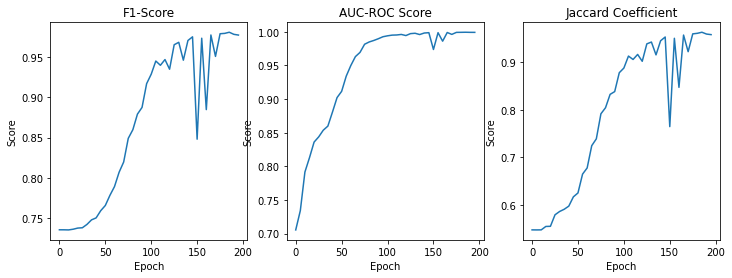

In [13]:
titles = ['F1-Score', 'AUC-ROC Score', 'Jaccard Coefficient']
figs, axs = plt.subplots(nrows=1, ncols=3, figsize =(12,4))
current = [F1_Score,AUC_Score,Dice_Score]

for j,ax in enumerate(axs.flatten()):
    plt.sca(ax)
    plt.title(titles[j])
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.plot(Epochs,current[j])

plt.show()

### 1.9 Visualize results(0.5 points)
For any 10 images in the dataset, show the images along the with their segmentation mask.


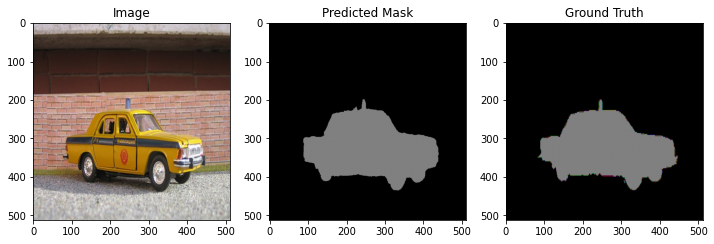

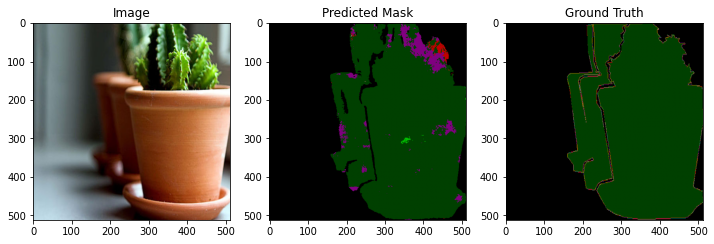

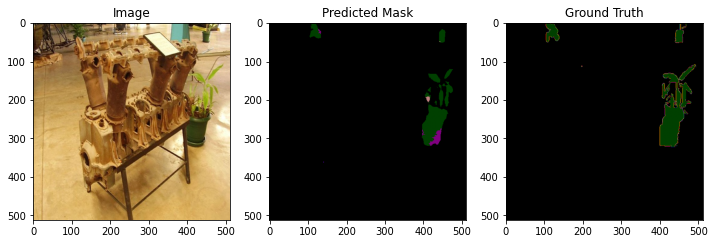

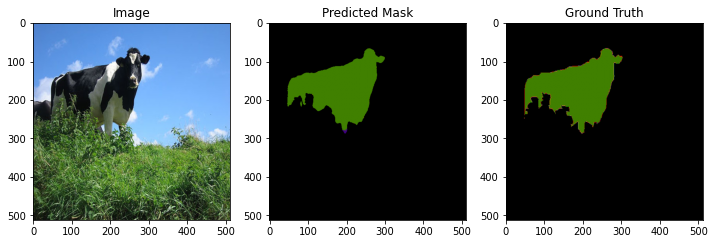

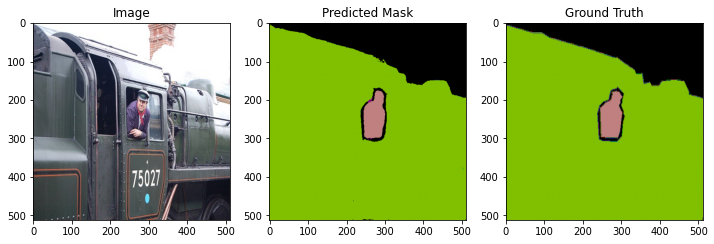

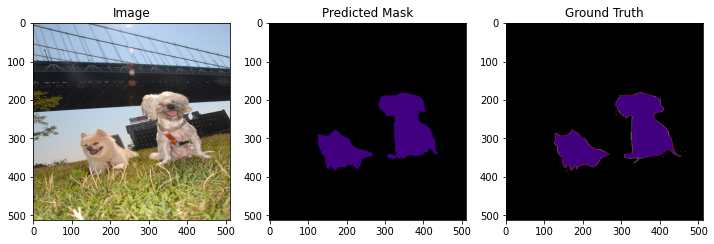

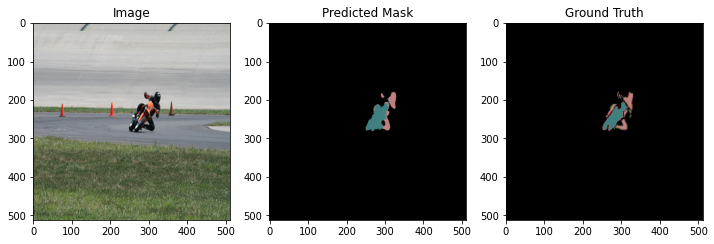

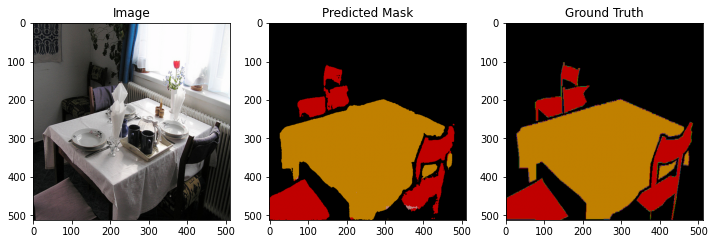

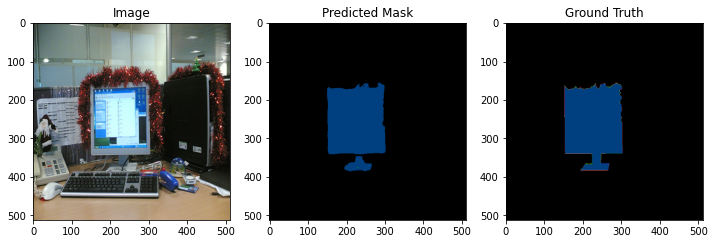

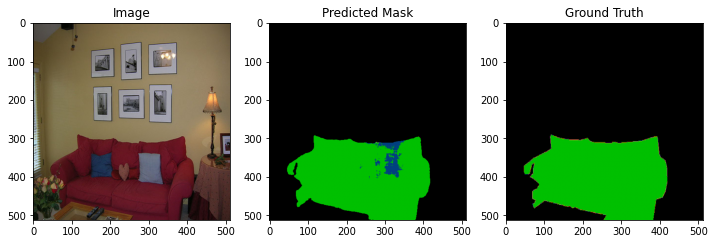

In [14]:
"""
Here we plot 10 images, their predicted mask by our model and the ground truth from the training data
in that respective order.
Since the model is trained on normalized data, we "unnormalize" the raw images before plotting.
"""

images = []
labels = []
prediction = []
iterator = enumerate(trainloader)

mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]
CUDA = False
model.cpu()
load_model(0,best_model=True)

for i in range(10):
    index, (image, label) = iterator.__next__()
    if CUDA:
        image = image.cuda(ID)
        label = label.cuda(ID)
    
    out = model(image)
    pred = torch.argmax(out[0], dim=0)
    pred = pred.cpu().numpy()
    img = image.new(*image.size())
    img[:,0,:,:] = image[:,0,:,:]*std[0]+mean[0]
    img[:,1,:,:] = image[:,1,:,:]*std[1]+mean[1]
    img[:,2,:,:] = image[:,2,:,:]*std[2]+mean[2]
    img = img[0].permute(1,2,0)
    images.append(img)
    prediction.append(dst.decode_segmap(pred))
    n2 = label.numpy()[0]
    labels.append(dst.decode_segmap(n2))
titles = ['Image','Predicted Mask', 'Ground Truth']
for i in range(10):    
    figs, axs = plt.subplots(nrows=1, ncols=3, figsize =(12,4))
    current = [images[i],prediction[i],labels[i]]
    for j,ax in enumerate(axs.flatten()):
        plt.sca(ax)
        plt.title(titles[j])
        plt.imshow(current[j])

    
    plt.show()

